<a href="https://colab.research.google.com/github/vongkhmer/NoteOnEfficientCPP/blob/master/RESNET_PRE_TRAINED_LIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!cp /content/drive/My\ Drive/TrainVal_images.zip .
!unzip TrainVal_images.zip
!unzip TrainVal_images.zip
!rm -f TrainVal_images.zip
!cp /content/drive/My\ Drive/TrainVal_pose_annotations.zip .
!unzip TrainVal_pose_annotations.zip
!rm -f TrainVal_pose_annotations.zip


Streaming output truncated to the last 5000 lines.
  inflating: val_images/363752_453520.jpg  
  inflating: val_images/363764_1729006.jpg  
  inflating: val_images/363821_233103.jpg  
  inflating: val_images/363908_487436.jpg  
  inflating: val_images/363969_424153.jpg  
  inflating: val_images/363969_475685.jpg  
  inflating: val_images/363987_183746.jpg  
  inflating: val_images/364073_500662.jpg  
  inflating: val_images/364079_186955.jpg  
  inflating: val_images/364082_448563.jpg  
  inflating: val_images/364099_434163.jpg  
  inflating: val_images/364102_436084.jpg  
  inflating: val_images/364126_437585.jpg  
  inflating: val_images/364174_185563.jpg  
  inflating: val_images/364256_472681.jpg  
  inflating: val_images/364283_186906.jpg  
  inflating: val_images/364293_491867.jpg  
  inflating: val_images/364433_476433.jpg  
  inflating: val_images/364448_470179.jpg  
  inflating: val_images/364458_211998.jpg  
  inflating: val_images/36447_226298.jpg  
  inflating: val_images/3

In [9]:
!mkdir preprocessed_train
!mkdir preprocessed_val

In [12]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from os import listdir
from os.path import isfile, join
import cv2
import scipy.io 
import keras.backend as K
import math
print(tf.__version__)

2.3.0


Image at: val_images/236759_439518.jpg
(463, 344, 3)


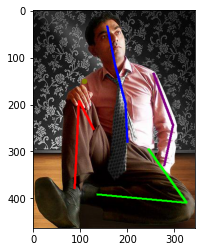

In [58]:
import csv
import sys
import random
import os
from PIL import Image, ImageDraw, ImageOps

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_joint(rec, img_folder):
  img_name = os.path.join(img_folder,rec[0])
  print('Image at: ' + img_name)
  img = Image.open(img_name)
  print(np.array(img).shape)
  draw = ImageDraw.Draw(img)
  r = 5
  bombs = [[0,1],[1,2]
			,[3,4],[4,5]
			,[6,7],[7,8],[8,9]
			,[10,11],[11,12]
			,[13,14], [14,15] ]
  colors = [(255,0,0),(255,0,0),
			  (0,255,0),(0,255,0),
			  (0,0,255),(0,0,255),(0,0,255),
			  (128,128,0),(128,128,0),
			  (128,0,128),(128,0,128)]
  r = 5 
  for b_id in range(len(bombs)):
    b = bombs[b_id]
    color = colors[b_id]
    x1 = rec[ b[0] * 3 + 1]
    y1 = rec[ b[0] * 3 + 2]
    v1 = rec[ b[0] * 3 + 3]
    
    x2 = rec[ b[1] * 3 + 1]
    y2 = rec[ b[1] * 3 + 2]
    v2 = rec[ b[1] * 3 + 3]
    
    if v1 != 'nan' and v2 != 'nan':
      draw.line((int(x1),int(y1), int(x2),int(y2)), fill = color, width = 5)
    elif v1 != 'nan':
      draw.ellipse((int(x1) - r, int(y1) - r, int(x1) + r, int(y1) + r), fill = color)
    elif v2 != 'nan':
      draw.ellipse((int(x2) - r, int(y2) - r, int(x2) + r, int(y2) + r), fill = color)
  plt.imshow(img)

def vis_anno(dataSet):
	csv_path = {
		'train': 'lip_train_set.csv' ,
		'valid': 'lip_val_set.csv',
		'test' :'lip_test_set.csv'
	}
	img_root = {
		'train': 'train_images/',
		'valid': 'val_images/',
		'test': 'notExist/',
	}
	with open(csv_path[dataSet]) as f:
		reader = csv.reader(f)
		recs = []
		for row in reader:
			recs.append(row)
		random_id = random.randint(0, len(recs) - 1)
		plot_joint(recs[random_id], img_root[dataSet])
  
dataSet = 'valid'
vis_anno(dataSet)


In [59]:
def heatmap_from_point(px, py, heatmap_size, heatmap_sigma):
  ans = np.zeros(heatmap_size)
  mu_x = math.floor(px * heatmap_size[0] + heatmap_size[0] / 2)
  mu_y = math.floor(py * heatmap_size[1] + heatmap_size[1] / 2)
  for i in range(heatmap_size[0]):
    for j in range(heatmap_size[1]):
      dist = (mu_x - j) ** 2 + (mu_y - i) ** 2
      if dist < (3 * heatmap_sigma) ** 2:
        ans[i,j] = np.exp( - dist / (2 * heatmap_sigma ** 2))
  return ans

def heatmap_from_joint_vector(joint_vect, joint_vis, heatmap_size, heatmap_sigma):
  # joint_vect : flatten_vect
  num_joints = joint_vect.shape[0] // 2
  ans = []
  for i in range(num_joints):
    if joint_vis[2 * i] < 0.5:
      hmp = np.zeros((heatmap_size[0], heatmap_size[1]))
      ans.append(hmp)
    else:
      px = joint_vect[2 * i]
      py = joint_vect[2 * i + 1]
      ans.append(heatmap_from_point(px, py, heatmap_size, heatmap_sigma))
  ans = np.stack(ans, axis=-1)
  return ans
default_heatmap_size = (220,220)
default_heatmap_sigma = 2

In [90]:
train_df = pd.DataFrame({"image_path":[], "joint_vector":[], "joint_valid":[], "heatmap":[]})
flip_pos = [(0,3), (1,4), (2,5), (10,13), (11,14), (12,15)]
count = 0
with open("lip_train_set.csv") as f:
  reader = csv.reader(f)
  for row in reader:
    count += 1
    if count > 10 : 
      break
    img_fn = os.path.join("train_images", row[0])
    print(img_fn)
    img = Image.open(img_fn)
    width, height = img.size
    img = img.resize((220,220))
    new_path = os.path.join("preprocessed_train", row[0])
    img.save(new_path)
    joint_vector = []
    joint_valid = []
    for i in range(16):
      pos_x = row[3*i + 1]
      pos_y = row[3*i + 2]
      exist = row[3*i + 3]
      if exist != 'nan':
        norm_x = (int(pos_x) - width // 2) / width
        norm_y = (int(pos_y) - height//2 ) / height
        joint_vector.append(norm_x)
        joint_vector.append(norm_y)
        joint_valid.append(1)
        joint_valid.append(1)
      else:
        joint_vector.append(0)
        joint_vector.append(0)
        joint_valid.append(0)
        joint_valid.append(0)
    joint_vector = np.array(joint_vector)
    joint_valid = np.array(joint_valid)
    hmp = heatmap_from_joint_vector(joint_vector, joint_valid, default_heatmap_size, default_heatmap_sigma)
    train_df = train_df.append({"image_path":new_path, "joint_vector":joint_vector, "joint_valid":joint_valid, "heatmap":hmp}, ignore_index=True)

    #mirroring
    flip_img = ImageOps.mirror(img)
    new_path = os.path.join("preprocessed_train", "flipped" + row[0])
    flip_img.save(new_path)
    flip_joint_vector = joint_vector.copy()
    flip_joint_valid = joint_valid.copy()
    for i in range(16):
      flip_joint_vector[2*i] = - flip_joint_vector[2*i]
    for fp in flip_pos:
      ind1 = fp[0]
      ind2 = fp[1]
      flip_joint_vector[2 * ind1] = joint_vector[2 * ind2]
      flip_joint_vector[2 * ind1 + 1] = joint_vector[2 * ind2 + 1]

      flip_joint_valid[2 * ind1] = joint_valid[2 * ind2]
      flip_joint_valid[2 * ind1 + 1] = joint_valid[2 * ind2 + 1]

      flip_joint_vector[2 * ind2] = joint_vector[2 * ind1]
      flip_joint_vector[2 * ind2 + 1] = joint_vector[2 * ind1 + 1]

      flip_joint_valid[2 * ind2] = joint_valid[2 * ind1]
      flip_joint_valid[2 * ind2 + 1] = joint_valid[2 * ind1 + 1]
    flip_joint_vector = np.array(flip_joint_vector)
    flip_joint_valid = np.array(flip_joint_valid)
    flip_hmp = heatmap_from_joint_vector(flip_joint_vector, flip_joint_valid, default_heatmap_size, default_heatmap_sigma)
    train_df = train_df.append({"image_path":new_path, "joint_vector":flip_joint_vector, "joint_valid":flip_joint_valid, "heatmap":flip_hmp}, ignore_index=True)
train_df


train_images/1000_1234574.jpg
train_images/100111_470108.jpg
train_images/10012_1730659.jpg
train_images/10014_189863.jpg
train_images/100159_1748699.jpg
train_images/100209_505823.jpg
train_images/100222_2157698.jpg
train_images/100231_439666.jpg
train_images/100238_533980.jpg
train_images/100277_496684.jpg


,image_path,joint_vector,joint_valid,heatmap
0,preprocessed_train/1000_1234574.jpg,"[-0.11904761904761904, 0.3521739130434783, -0....","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
1,preprocessed_train/flipped1000_1234574.jpg,"[0.23809523809523808, -0.008695652173913044, 0...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
2,preprocessed_train/100111_470108.jpg,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
3,preprocessed_train/flipped100111_470108.jpg,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
4,preprocessed_train/10012_1730659.jpg,"[0.31683168316831684, 0.40066225165562913, 0.2...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
5,preprocessed_train/flipped10012_1730659.jpg,"[-0.22772277227722773, -0.08278145695364239, -...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
6,preprocessed_train/10014_189863.jpg,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, ...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
7,preprocessed_train/flipped10014_189863.jpg,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, ...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
8,preprocessed_train/100159_1748699.jpg,"[-0.3473684210526316, 0.41694915254237286, -0....","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
9,preprocessed_train/flipped100159_1748699.jpg,"[0.17894736842105263, -0.06440677966101695, 0....","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."


In [ ]:
val_df = pd.DataFrame({"image_path":[], "joint_vector":[], "joint_valid":[]})
with open("lip_val_set.csv") as f:
  reader = csv.reader(f)
  for row in reader:
    img_fn = os.path.join("val_images", row[0])
    img = Image.open(img_fn)
    width, height = img.size
    img = img.resize((220,220))
    new_path = os.path.join("preprocessed_val", row[0])
    img.save(new_path)
    joint_vector = []
    joint_valid = []
    for i in range(16):
      pos_x = row[3*i + 1]
      pos_y = row[3*i + 2]
      exist = row[3*i + 3]
      if exist != 'nan':
        norm_x = (int(pos_x) - width // 2) / width
        norm_y = (int(pos_y) - height//2 ) / height
        joint_vector.append(norm_x)
        joint_vector.append(norm_y)
        joint_valid.append(1)
        joint_valid.append(1)
      else:
        joint_vector.append(0)
        joint_vector.append(0)
        joint_valid.append(0)
        joint_valid.append(0)

    val_df = val_df.append({"image_path":new_path, "joint_vector":np.array(joint_vector), "joint_valid":np.array(joint_valid)}, ignore_index=True)
val_df

,image_path,joint_vector,joint_valid
0,preprocessed_val/100034_483681.jpg,"[0.32085561497326204, 0.3309692671394799, 0.15...","[1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,preprocessed_val/10005_205677.jpg,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, ..."
2,preprocessed_val/100142_449784.jpg,"[-0.32335329341317365, 0.38301886792452833, -0...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,preprocessed_val/10014_1211482.jpg,"[0.019230769230769232, 0.38321167883211676, -0...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,preprocessed_val/10024_490664.jpg,"[-0.13740458015267176, 0.3543859649122807, -0....","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
...,...,...,...
9995,preprocessed_val/9960_488732.jpg,"[-0.3287671232876712, 0.2922077922077922, -0.1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
9996,preprocessed_val/99681_521075.jpg,"[-0.045112781954887216, 0.4090909090909091, 0....","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
9997,preprocessed_val/99807_183413.jpg,"[-0.1794871794871795, 0.38738738738738737, -0....","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
9998,preprocessed_val/99938_1719104.jpg,"[-0.19747899159663865, 0.3041825095057034, -0....","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [42]:
def plot_nomalized_joint(img_arr, joint_vector, joint_valid):
  if np.max(img_arr) < 2:
    img_arr = np.array(img_arr) * 255.0
    img_arr = img_arr.astype(np.uint8)
  img = Image.fromarray(img_arr)
  draw = ImageDraw.Draw(img)
  r = 5
  height, width, _ = img_arr.shape
  bombs = [[0,1],[1,2]
			,[3,4],[4,5]
			,[6,7],[7,8],[8,9]
			,[10,11],[11,12]
			,[13,14],[14,15]]
  colors = [(255,0,0),(255,0,0),
			  (0,255,0),(0,255,0),
			  (0,0,255),(0,0,255),(0,0,255),
			  (128,128,0),(128,128,0),
			  (128,0,128),(128,0,128)]
  r = 5 
  for b_id in range(len(bombs)):
    b = bombs[b_id]
    color = colors[b_id]
    x1 = joint_vector[2 * b[0]]
    x1 = x1 * width + width // 2
    y1 = joint_vector[2 * b[0] + 1]
    y1 = y1 * height + height // 2
    v1 = joint_valid[2 * b[0]]
    
    x2 = joint_vector[2 * b[1]]
    x2 = x2 * width + width //2
    y2 = joint_vector[2 * b[1] + 1]
    y2 = y2 * height + height // 2
    v2 = joint_valid[2 * b[1]]
    
    if v1 != 0 and v2 != 0:
      draw.line((int(x1),int(y1), int(x2),int(y2)), fill = color, width = 5)
      draw.ellipse((int(x1) - r, int(y1) - r, int(x1) + r, int(y1) + r), fill = color)
      draw.ellipse((int(x2) - r, int(y2) - r, int(x2) + r, int(y2) + r), fill = color)
    elif v1 != 0:
      draw.ellipse((int(x1) - r, int(y1) - r, int(x1) + r, int(y1) + r), fill = color)
    elif v2 != 0:
      draw.ellipse((int(x2) - r, int(y2) - r, int(x2) + r, int(y2) + r), fill = color)
  plt.imshow(img)

preprocessed_train/100238_533980.jpg
(32,)


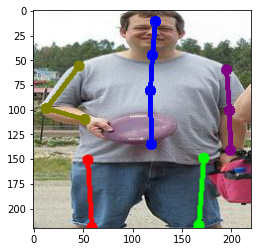

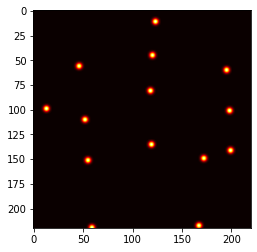

In [89]:
test_index = np.random.randint(0,10)
img = train_df.loc[test_index]["image_path"]
print(img)
img_arr = np.array(Image.open(img))
joint_vector = train_df.loc[test_index]["joint_vector"]
joint_valid = train_df.loc[test_index]["joint_valid"]
hmp = train_df.loc[test_index]["heatmap"]
print(joint_vector.shape)
#print(img)
#print(joint_vector)
plot_nomalized_joint(img_arr, joint_vector, joint_valid)
plt.show()
plt.imshow(np.sum(hmp, axis=-1), cmap="hot")
plt.show()

In [ ]:
image_path = train_df["image_path"]
joint_vector = train_df["joint_vector"]
joint_vector = np.stack(joint_vector)
print(joint_vector.shape)
joint_valid = train_df["joint_valid"]
joint_valid = np.stack(joint_valid)

data_dict = {"image_path":image_path, "joint_vector":joint_vector, "joint_valid":joint_valid}

train_data = tf.data.Dataset.from_tensor_slices(data_dict)

val_image_path = val_df["image_path"]
val_joint_vector = val_df["joint_vector"]
val_joint_vector = np.stack(val_joint_vector)
print(val_joint_vector.shape)
val_joint_valid = val_df["joint_valid"]
val_joint_valid = np.stack(val_joint_valid)

val_data_dict = {"image_path":val_image_path, "joint_vector":val_joint_vector, "joint_valid":val_joint_valid}

train_data = tf.data.Dataset.from_tensor_slices(data_dict)
val_data = tf.data.Dataset.from_tensor_slices(val_data_dict)

def preprocess(image_info):
  image_path = image_info["image_path"]
  joint_vector = image_info["joint_vector"]
  joint_valid = image_info["joint_valid"]
  image = tf.io.read_file(image_path)
  image = tf.image.decode_jpeg(image)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image_shape = tf.shape(image)
  if image_shape[-1] < 3 :
    image = tf.image.grayscale_to_rgb(image)
  return (image, joint_valid), joint_vector

train_data = train_data.shuffle(buffer_size=60924, seed=72, reshuffle_each_iteration=False)
train_data = train_data.map(preprocess, num_parallel_calls=2)
val_data = val_data.map(preprocess, num_parallel_calls=2)
train_data_iter = iter(train_data)
val_data_iter = iter(val_data)

(60924, 32)
(10000, 32)


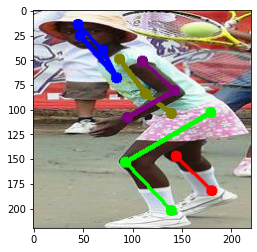

In [ ]:
(img_arr, jva), jve = next(val_data_iter)
#img_arr = np.array(img_arr) * 255.0
#img_arr = img_arr.astype(np.uint8)
plot_nomalized_joint(img_arr, jve, jva)

In [94]:
def euclidean_distance_loss(y_true, y_pred):
    #can I add joint_valid_info here??
    return K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1))

def cust_loss(y,y_pred):
  return tf.reduce_mean(tf.reduce_sum(tf.square(tf.subtract(y, y_pred)), 1))

image_input_shape = (220,220,3)

resnet_pretrained = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=(220,220,3))
resnet_pretrained.trainable = False
resnet_pretrained.summary()
input_tensor = tf.keras.Input(shape=image_input_shape)
input_joints_valid = tf.keras.Input(shape=(32))
x = resnet_pretrained(input_tensor)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(units=1024, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(units=512, activation="relu")(x)
output_joints_vector = tf.keras.layers.Dense(units=32)(x)
output_joints_vector_valid = tf.keras.layers.multiply([input_joints_valid, output_joints_vector])
vgg_pose_model = tf.keras.Model(inputs=[input_tensor, input_joints_valid], outputs=output_joints_vector_valid)
#vgg_pose_model.summary()
vgg_pose_model.compile(loss=cust_loss, optimizer=tf.keras.optimizers.Adagrad(learning_rate=1e-3))

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 220, 220, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 226, 226, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 110, 110, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 110, 110, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
batch_size = 64
EPOCH = 10
train_data = train_data.batch(batch_size)
train_data = train_data.prefetch(2)
val_data = val_data.batch(batch_size)
val_data = val_data.prefetch(2)
training_hist = []
val_hist = []

In [ ]:
class MyCustomCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    loss = logs.get('loss')
    val_loss = logs.get('val_loss')
    training_hist.append(loss)
    val_hist.append(val_loss)

    if epoch % 10 == 0:
      print("loss at epoch", epoch, loss, "val_loss", val_loss)

    if  epoch % 50 == 0:
      self.model.save("drive/My Drive/LIP_VGG_MODELS/vggmodel_pretrained_epoch_" + str(epoch) + ".h5")

callback1 = MyCustomCallback()
history = vgg_pose_model.fit(train_data, validation_data=val_data, verbose=2, epochs=300, callbacks=[callback1])


Epoch 1/300
loss at epoch 0 0.5693796277046204 val_loss 0.7593869566917419
952/952 - 128s - loss: 0.5694 - val_loss: 0.7594
Epoch 2/300
952/952 - 126s - loss: 0.5684 - val_loss: 0.7576
Epoch 3/300
952/952 - 126s - loss: 0.5666 - val_loss: 0.7578
Epoch 4/300
952/952 - 126s - loss: 0.5653 - val_loss: 0.7576
Epoch 5/300
952/952 - 126s - loss: 0.5637 - val_loss: 0.7566
Epoch 6/300
952/952 - 126s - loss: 0.5632 - val_loss: 0.7561
Epoch 7/300
952/952 - 126s - loss: 0.5595 - val_loss: 0.7568
Epoch 8/300
952/952 - 126s - loss: 0.5601 - val_loss: 0.7543
Epoch 9/300
952/952 - 126s - loss: 0.5582 - val_loss: 0.7563
Epoch 10/300
952/952 - 126s - loss: 0.5568 - val_loss: 0.7554
Epoch 11/300
loss at epoch 10 0.5557742118835449 val_loss 0.7560569047927856
952/952 - 126s - loss: 0.5558 - val_loss: 0.7561
Epoch 12/300
952/952 - 126s - loss: 0.5543 - val_loss: 0.7554
Epoch 13/300
952/952 - 126s - loss: 0.5521 - val_loss: 0.7557
Epoch 14/300
952/952 - 126s - loss: 0.5521 - val_loss: 0.7545
Epoch 15/300
9

KeyboardInterrupt: ignored

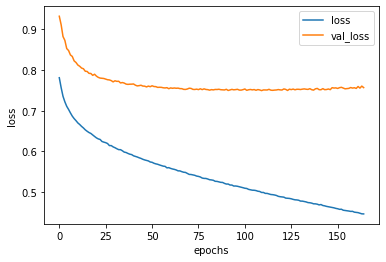

In [ ]:
plt.plot(training_hist, label="loss")
plt.plot(val_hist, label="val_loss")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()
vgg_pose_model.save("drive/My Drive/LIP_VGG_MODELS/vggmodel_300.h5")

In [ ]:
history = vgg_pose_model.fit(train_data, validation_data=val_data, verbose=0, epochs=1000, callbacks=[callback1])

training_hist = training_hist + history.history["loss"]
val_hist = val_hist + history.history["val_loss"]

plt.plot(training_hist, label="loss")
plt.plot(val_hist, label="val_loss")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()
vgg_pose_model.save("drive/My Drive/LIP_VGG_MODELS/vggmodel_1500.h5")